In [ ]:
from tensorflow.keras import models

model_name = "latest.keras"
loaded_model = models.load_model(model_name)

In [ ]:
from ipywidgets import FileUpload, Output
import cv2
import numpy as np
from IPython.display import display  # Use the display function from IPython.display
import matplotlib.pyplot as plt

# Function to replace black pixels with surrounding color
def replace_black_with_surrounding_color_optimized(img):
    result = img.copy()
    height, width, _ = img.shape
    black_mask = np.all(img == [0, 0, 0], axis=-1)
    accumulator = np.zeros_like(img, dtype=np.float32)
    surrounding_count = np.zeros((height, width), dtype=np.float32)

    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue

            rolled_img = np.roll(np.roll(img, shift=dy, axis=0), shift=dx, axis=1)
            non_black_mask = np.all(rolled_img != [0, 0, 0], axis=-1)
            accumulator += rolled_img * non_black_mask[..., np.newaxis]
            surrounding_count += non_black_mask

    surrounding_count[surrounding_count == 0] = 1
    result[black_mask] = (accumulator[black_mask] / surrounding_count[black_mask, np.newaxis]).astype(np.uint8)
    return result

# Function to display images side by side
def display_images(original, processed):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    ax[1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Processed Image")
    ax[1].axis("off")
    plt.show()

# File upload widget
upload_widget = FileUpload(accept='image/*', multiple=False)  # Ensure only one file is uploaded
output = Output()
final_image = None

def on_upload_change(change):
    global final_image  # Ensure final_image is updated globally
    with output:
        output.clear_output()  # Clear previous outputs

        # Process only if a single file is uploaded
        if len(upload_widget.value) == 1:
            # Get the first (and only) file
            file_info = next(iter(upload_widget.value.values()))

            # Load image from upload widget as OpenCV image
            image_bytes = file_info['content']
            image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)

            # Process the image
            processed_image = replace_black_with_surrounding_color_optimized(image)

            # Display images
            display_images(image, processed_image)

            # Store processed image in final_image
            final_image = processed_image

upload_widget.observe(on_upload_change, names='value')
display(upload_widget, output)


FileUpload(value={}, accept='image/*', description='Upload')

Output()

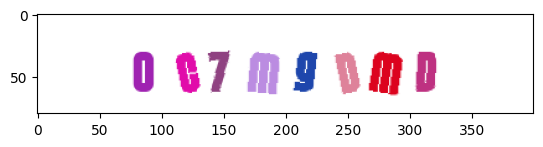

In [ ]:
processed_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
plt.imshow(processed_rgb)

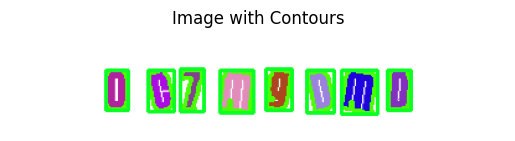

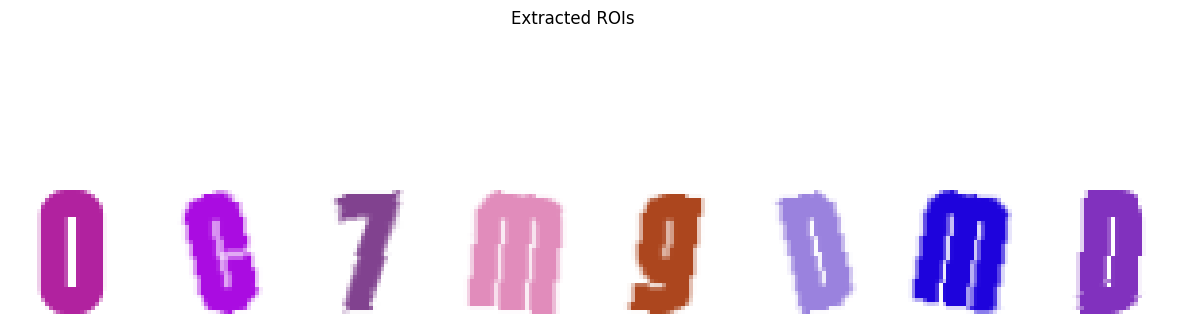

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Output folder for extracted ROIs
output_char_folder = "./data/extracted_chars"
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)

contour_too_small_threshold = 8

def extract_rois_from_image(processed_img):
    # Convert to grayscale and apply thresholding
    gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_with_contours = processed_img.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 75), 2)

    # Sort contours from left to right
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    rois = []  # List to store ROIs for display later
    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w <= contour_too_small_threshold and h <= contour_too_small_threshold:
            continue

        # Draw bounding box on the image
        cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (36, 255, 12), 2)

        # Extract ROI
        ROI = processed_img[y : y + h, x : x + w]

        # Padding and resizing
        if w > h:
            pad_top = (w - h) // 2
            pad_bottom = w - h - pad_top
            ROI_padded = cv2.copyMakeBorder(
                ROI, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )
        else:
            pad_left = (h - w) // 2
            pad_right = h - w - pad_left
            ROI_padded = cv2.copyMakeBorder(
                ROI, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=(255, 255, 255)
            )

        resized_ROI = cv2.resize(ROI_padded, (32, 32))
        rois.append(resized_ROI)

    return img_with_contours, rois  # Return image with contours and list of ROIs

# Process the single processed image
img_with_contours, rois = extract_rois_from_image(processed_rgb)

# Display the image with contours
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Image with Contours")
plt.axis("off")
plt.show()

# Display extracted ROIs
fig, axes = plt.subplots(1, len(rois), figsize=(15, 5))
for ax, roi in zip(axes, rois):
    ax.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    ax.axis("off")
plt.suptitle("Extracted ROIs")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


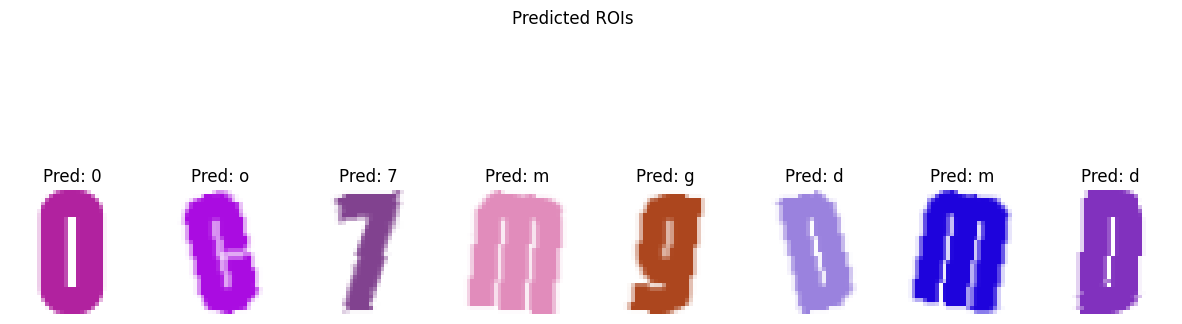

Final Answer: 0o7mgdmd


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load your Keras model (update the path to your model file)
model = load_model("latest.keras")

# Define the character list for decoding
digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]
char_list = digits + letters

# Function to decode predictions
def decode_predictions(preds):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)
    decoded_labels = label_encoder.inverse_transform(preds.argmax(axis=1))
    return decoded_labels

# Function to predict on each ROI using the loaded model
def predict_on_rois(rois, model):
    predictions = []
    final = ''
    for roi in rois:
        # Convert ROI to grayscale
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Preprocess ROI for model input (assuming model input shape is (32, 32, 1))
        roi_resized = cv2.resize(roi_gray, (32, 32))  # Resize to model's input size if needed
        roi_normalized = roi_resized / 255.0  # Normalize pixel values to [0, 1]
        roi_expanded = np.expand_dims(roi_normalized, axis=-1)  # Add channel dimension (shape: (32, 32, 1))
        roi_expanded = np.expand_dims(roi_expanded, axis=0)  # Add batch dimension (shape: (1, 32, 32, 1))

        # Predict with model
        prediction = model.predict(roi_expanded)
        final += decode_predictions(prediction)[0]

    return final

# Assuming extract_rois_from_image and processed_rgb are defined from previous steps
img_with_contours, rois = extract_rois_from_image(processed_rgb)

# Get predictions for each ROI
predictions = predict_on_rois(rois, model)

# Display the results
fig, axes = plt.subplots(1, len(rois), figsize=(15, 5))
for ax, roi, prediction in zip(axes, rois, predictions):
    ax.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))  # Display original ROI
    ax.set_title(f"Pred: {prediction}")
    ax.axis("off")
plt.suptitle("Predicted ROIs")
plt.show()

print(f'Final Answer: {predictions}')